In [23]:
depth = 64 #This is only used in title
# run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u_maze_616_20250106-235618" #4
# run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u_maze_266_20250106-235718" #16
# run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u_maze_1_20250107-082334" #32
# run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u_maze_627_20250106-235716" #8
# run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u5_maze_948_20250107-004339" #4 (u5_maze)
run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u5_maze_828_20250105-063306" #64 (u5_maze) ONLY PARTIAL THOUGH
# run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u5_maze_364_20250107-163016" #100
# run_dir = "/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u5_maze_492_20250111-230753" #64
args_path = f"{run_dir}/args.pkl"
# params_path = f"{run_dir}/step_197352448.pkl"
# params_path = f"{run_dir}/step_50726912.pkl"
params_path = f"{run_dir}/final.pkl"

# params_path = f"{run_dir}/final.pkl"
eval_env_id = "ant_u5_maze_single_eval" #if you want to use the env_id in args.eval_env_id, leave this as None

In [24]:
import pickle
import os
import jax
import flax
import tyro
import time
import optax
import wandb
import pickle
import random
import wandb_osh
import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt

from brax import envs
from etils import epath
from dataclasses import dataclass
from collections import namedtuple
from typing import NamedTuple, Any
from wandb_osh.hooks import TriggerWandbSyncHook
from flax.training.train_state import TrainState
from flax.linen.initializers import variance_scaling
from brax.io import html
from brax.io import model

from evaluator import CrlEvaluator
from buffer import TrajectoryUniformSamplingQueue
from memory_bank import MemoryBank, MemoryBankState

In [25]:
#COPY OVER DEFINITIONS
@dataclass
class Args:
    exp_name: str = "train" # os.path.basename(__file__)[: -len(".py")]
    seed: int = random.randint(1, 1000) # 16
    torch_deterministic: bool = True
    cuda: bool = True
    track: bool = True
    wandb_project_name: str = "clean_JaxGCRL_test"
    wandb_entity: str = 'wang-kevin3290-princeton-university'
    wandb_mode: str = 'offline'
    wandb_dir: str = '.'
    wandb_group: str = '.'
    capture_vis: bool = True
    vis_length: int = 1000
    checkpoint: bool = True

    #environment specific arguments
    env_id: str = "humanoid" # "ant_push" "ant_hardest_maze" "ant_big_maze" "humanoid" "ant"
    episode_length: int = 1000
    # to be filled in runtime
    obs_dim: int = 0
    goal_start_idx: int = 0
    goal_end_idx: int = 0

    # Algorithm specific arguments
    total_env_steps: int = 100000000 # 50000000
    num_epochs: int = 100 # 50
    num_envs: int = 512
    eval_env_id: str = ""
    num_eval_envs: int = 128
    actor_lr: float = 3e-4
    critic_lr: float = 3e-4
    alpha_lr: float = 3e-4
    batch_size: int = 256
    gamma: float = 0.99
    logsumexp_penalty_coeff: float = 0.1
    
    #adding in a batch_size_multiplier argument for critic vs. actor batch size
    critic_batch_size_multiplier: float = 1.0 #this has to be less than or equal to 1
    actor_batch_size_multiplier: float = 1.0 #this has to be less than 1

    max_replay_size: int = 10000
    min_replay_size: int = 1000
    
    unroll_length: int  = 62
    
    # ADDING IN A NETWORK WIDTH ARGUMENT
    same_network_width: int = 0
    network_width: int = 256
    critic_network_width: int = 256
    actor_network_width: int = 256
    actor_depth: int = 4
    critic_depth: int = 4
    actor_skip_connections: int = 0 # 0 for no skip connections, >= 0 means the frequency of skip connections (every X layers)
    critic_skip_connections: int = 0 # 0 for no skip connections, >= 0 means the frequency of skip connections (every X layers)
    
    num_episodes_per_env: int = 1 #the number of episodes to sample from each env when sampling data 
    #(to ensure number of batches is consistent as increase batch_size; for now, just a bandaid fix)
    # should be something like batch_size / 256
    training_steps_multiplier: int = 1 #should have the same effect as num_episodes_per_env, hmmm
    use_all_batches: int = 0 # if 1, use all batches; if 0, use a random subset of batches
    num_sgd_batches_per_training_step: int = 800 # this parameter so as to hold the number of batches constant (no matter batch_size, etc)
    
    mrn: int = 0
    memory_bank: int = 0
    memory_bank_size: int = batch_size # this can be modified too
    
    batchdiv2: int = 0 
    # if 1, freeze gradients for second half of batch
    # if 2, split in half along sa and freeze second half of g (Eysenbach ablation, remember it's forward loss)
    #
    # use batch_size * 2 and split in half and freeze gradients and all that (Eysenbach ablation), does not 
    # TODO: if 2, modifies actor such that it uses the half batch size (isolate for critic ablation)
    # can add 3, 4, etc (if diff between 1 and 2, maybe for batch_size ablation we need to have separate for actor and critic)
    # add more for instead of discarding second half, just freeze gradients for second half so symmetric with first
    
    eval_actor: int = 0
    # if 0, use deterministic actor for evaluation
    # if 1, use stochastic actor for evaluation
    # if 2, sample two actions and take the one with the higher Q value
    # if K >= 2, sample K actions and take the one with the highest Q value
    expl_actor: int = 1
    # if 0, use deterministic actor for exploration/collecting data
    # if 1, use stochastic actor for exploration/collecting data
    # if 2, sample two actions and take the one with the higher Q value
    # if K >= 2, sample K actions and take the one with the highest Q value
    
    entropy_param: float = 0.5
    disable_entropy: int = 0
    
    use_relu: int = 0
    
    resnet: str = "noishmistake4_nodense"
    
    num_render: int = 10
    
    
    
    # to be filled in runtime
    env_steps_per_actor_step : int = 0
    """number of env steps per actor step (computed in runtime)"""
    num_prefill_env_steps : int = 0
    """number of env steps to fill the buffer before starting training (computed in runtime)"""
    num_prefill_actor_steps : int = 0
    """number of actor steps to fill the buffer before starting training (computed in runtime)"""
    num_training_steps_per_epoch : int = 0
    """the number of training steps per epoch(computed in runtime)"""

In [26]:
def make_env(env_id, args):
    print(f"making env with env_id: {env_id}", flush=True)
    if env_id == "reacher":
        from envs.reacher import Reacher
        env = Reacher(
            backend="spring",
        )
        args.obs_dim = 10
        args.goal_start_idx = 4
        args.goal_end_idx = 7
    elif env_id == "pusher":
        from envs.pusher import Pusher
        env = Pusher(
            backend="spring",
        )
        args.obs_dim = 20
        args.goal_start_idx = 10
        args.goal_end_idx = 13
    elif env_id == "ant":
        from envs.ant import Ant
        env = Ant(
            backend="spring",
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        )

        args.obs_dim = 29
        args.goal_start_idx = 0
        args.goal_end_idx = 2

    elif "ant" in env_id and "maze" in env_id: #needed the add the ant check to differentiate with humanoid maze
        if "gen" not in env_id:
            from envs.ant_maze import AntMaze
            env = AntMaze(
                backend="spring",
                exclude_current_positions_from_observation=False,
                terminate_when_unhealthy=True,
                maze_layout_name=env_id[4:]
            )

            # args.obs_dim = 29
            # args.goal_start_idx = 0
            # args.goal_end_idx = 2
        else:
            from envs.ant_maze_generalization import AntMazeGeneralization
            gen_idx = env_id.find("gen")
            maze_layout_name = env_id[4:gen_idx-1]
            generalization_config = env_id[gen_idx+4:]
            print(f"maze_layout_name: {maze_layout_name}, generalization_config: {generalization_config}", flush=True)
            env = AntMazeGeneralization(
                backend="spring",
                exclude_current_positions_from_observation=False,
                terminate_when_unhealthy=True,
                maze_layout_name=maze_layout_name,
                generalization_config=generalization_config
            )

            args.obs_dim = 29
            args.goal_start_idx = 0
            args.goal_end_idx = 2
    
    elif env_id == "ant_ball":
        from envs.ant_ball import AntBall
        env = AntBall(
            backend="spring",
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        )

        args.obs_dim = 31
        args.goal_start_idx = 28
        args.goal_end_idx = 30

    elif env_id == "ant_push":
        from envs.ant_push import AntPush
        env = AntPush(
            backend="mjx",
        )

        args.obs_dim = 31
        args.goal_start_idx = 0
        args.goal_end_idx = 2
        
    elif env_id == "humanoid":
        from envs.humanoid import Humanoid
        env = Humanoid(
            backend="spring",
            exclude_current_positions_from_observation=False,
            terminate_when_unhealthy=True,
        )

        args.obs_dim = 268
        args.goal_start_idx = 0
        args.goal_end_idx = 3
        
    elif "humanoid" in env_id and "maze" in env_id:
        from envs.humanoid_maze import HumanoidMaze
        env = HumanoidMaze(
            backend="spring",
            maze_layout_name=env_id[9:]
        )

        args.obs_dim = 268
        args.goal_start_idx = 0
        args.goal_end_idx = 3

        
    elif env_id == "arm_reach":
        from envs.manipulation.arm_reach import ArmReach
        env = ArmReach(
            backend="mjx",
        )

        args.obs_dim = 13
        args.goal_start_idx = 7
        args.goal_end_idx = 10
        
    elif env_id == "arm_binpick_easy":
        from envs.manipulation.arm_binpick_easy import ArmBinpickEasy
        env = ArmBinpickEasy(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3
        
    elif env_id == "arm_binpick_hard":
        from envs.manipulation.arm_binpick_hard import ArmBinpickHard
        env = ArmBinpickHard(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3
        
    elif env_id == "arm_binpick_easy_EEF":
        from envs.manipulation.arm_binpick_easy_EEF import ArmBinpickEasyEEF
        env = ArmBinpickEasyEEF(
            backend="mjx",
        )

        args.obs_dim = 11
        args.goal_start_idx = 0
        args.goal_end_idx = 3
    
    elif "arm_grasp" in env_id: # either arm_grasp or arm_grasp_0.5, etc
        from envs.manipulation.arm_grasp import ArmGrasp
        cube_noise_scale = float(env_id[10:]) if len(env_id) > 9 else 0.3
        env = ArmGrasp(
            cube_noise_scale=cube_noise_scale,
            backend="mjx",
        )

        args.obs_dim = 23
        args.goal_start_idx = 16
        args.goal_end_idx = 23
    
    elif env_id == "arm_push_easy":
        from envs.manipulation.arm_push_easy import ArmPushEasy
        env = ArmPushEasy(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3
    
    elif env_id == "arm_push_hard":
        from envs.manipulation.arm_push_hard import ArmPushHard
        env = ArmPushHard(
            backend="mjx",
        )

        args.obs_dim = 17
        args.goal_start_idx = 0
        args.goal_end_idx = 3

    else:
        raise NotImplementedError
    
    return env

In [27]:
lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
bias_init = nn.initializers.zeros
def residual_block(x, width, normalize, activation):
    identity = x
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = nn.Dense(width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
    x = normalize(x)
    x = activation(x)
    x = x + identity
    return x

class SA_encoder(nn.Module):
    norm_type = "layer_norm"
    network_width: int = 1024
    network_depth: int = 4
    skip_connections: int = 0
    use_relu: int = 0
    @nn.compact
    def __call__(self, s: jnp.ndarray, a: jnp.ndarray):

        lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
        bias_init = nn.initializers.zeros
        
        if self.norm_type == "layer_norm":
            normalize = lambda x: nn.LayerNorm()(x)
        else:
            normalize = lambda x: x
        
        if self.use_relu:
            activation = nn.relu
        else:
            activation = nn.swish
            
        x = jnp.concatenate([s, a], axis=-1)
        #Initial layer
        x = nn.Dense(self.network_width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        x = normalize(x)
        x = activation(x)
        #Residual blocks
        for i in range(self.network_depth // 4):
            x = residual_block(x, self.network_width, normalize, activation)
        #Final layer
        x = nn.Dense(64, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        return x
    
class G_encoder(nn.Module):
    norm_type = "layer_norm"
    network_width: int = 1024
    network_depth: int = 4
    skip_connections: int = 0
    use_relu: int = 0
    @nn.compact
    def __call__(self, g: jnp.ndarray):

        lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
        bias_init = nn.initializers.zeros

        if self.norm_type == "layer_norm":
            normalize = lambda x: nn.LayerNorm()(x)
        else:
            normalize = lambda x: x
        
        if self.use_relu:
            activation = nn.relu
        else:
            activation = nn.swish
        
        x = g
        #Initial layer
        x = nn.Dense(self.network_width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        x = normalize(x)
        x = activation(x)
        #Residual blocks
        for i in range(self.network_depth // 4):
            x = residual_block(x, self.network_width, normalize, activation)
        #Final layer
        x = nn.Dense(64, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        return x

class Actor(nn.Module):
    action_size: int
    norm_type = "layer_norm"
    network_width: int = 1024
    network_depth: int = 4
    skip_connections: int = 0 # 0 for no skip connections, >= 0 means the frequency of skip connections (every X layers)
    use_relu: int = 0
    LOG_STD_MAX = 2
    LOG_STD_MIN = -5

    @nn.compact
    def __call__(self, x):
        if self.norm_type == "layer_norm":
            normalize = lambda x: nn.LayerNorm()(x)
        else:
            normalize = lambda x: x
            
        if self.use_relu:
            activation = nn.relu
        else:
            activation = nn.swish

        lecun_unfirom = variance_scaling(1/3, "fan_in", "uniform")
        bias_init = nn.initializers.zeros
        
        #Initial layer
        x = nn.Dense(self.network_width, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        x = normalize(x)
        x = activation(x)
        #Residual blocks
        for i in range(self.network_depth // 4):
            x = residual_block(x, self.network_width, normalize, activation)
        #Final layer
        # x = nn.Dense(64, kernel_init=lecun_unfirom, bias_init=bias_init)(x)

        mean = nn.Dense(self.action_size, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        log_std = nn.Dense(self.action_size, kernel_init=lecun_unfirom, bias_init=bias_init)(x)
        
        log_std = nn.tanh(log_std)
        log_std = self.LOG_STD_MIN + 0.5 * (self.LOG_STD_MAX - self.LOG_STD_MIN) * (log_std + 1)  # From SpinUp / Denis Yarats

        return mean, log_std

In [28]:
with open(args_path, 'rb') as f:
    args = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/gpfs/kw6487/JaxGCRL/clean_JaxGCRL/runs/ant_u5_maze_828_20250105-063306/args.pkl'

In [15]:
if eval_env_id:
    env = make_env(eval_env_id, None)
else:
    env = make_env(args.eval_env_id, args)

obs_size = env.observation_size
action_size = env.action_size

making env with env_id: ant_u5_maze_single_eval


In [16]:
params = model.load_params(params_path)
alpha_params, actor_params, critic_params = params
sa_encoder_params, g_encoder_params = critic_params['sa_encoder'], critic_params['g_encoder']
actor = Actor(action_size=action_size, network_width=args.actor_network_width, network_depth=args.actor_depth, skip_connections=args.actor_skip_connections, use_relu=args.use_relu)
sa_encoder = SA_encoder(network_width=args.critic_network_width, network_depth=args.critic_depth, skip_connections=args.critic_skip_connections, use_relu=args.use_relu)
g_encoder = G_encoder(network_width=args.critic_network_width, network_depth=args.critic_depth, skip_connections=args.critic_skip_connections, use_relu=args.use_relu)

In [9]:
# params = model.load_params(params_path)
# alpha_params, actor_params, critic_params = params
# sa_encoder_params, g_encoder_params = critic_params['sa_encoder'], critic_params['g_encoder']
# actor = Actor(action_size=action_size, network_width=256, network_depth=64, skip_connections=4, use_relu=0)
# sa_encoder = SA_encoder(network_width=256, network_depth=64, skip_connections=4, use_relu=0)
# g_encoder = G_encoder(network_width=256, network_depth=64, skip_connections=4, use_relu=0)

In [10]:
# env = make_env(args.)

# # Initialize environment
# rng = jax.random.PRNGKey(seed=i+1)
# env_state = jax.jit(env.reset)(rng)

# # Collect rollout using jitted function
# for j in range(vis_length):
#     if j % 10 == 0:
#         print(f"j: {j}", flush=True)
#     env_state, current_state = policy_step(env_state, actor_params)
#     rollout_states.append(current_state.pipeline_state)

In [11]:
# #ant_u_maze
# SEED = 4237

# rng = jax.random.PRNGKey(seed=SEED)
# env_state = jax.jit(env.reset)(rng)

# obs = np.array(env_state.obs)
# goal = obs[-2:]
# print(f"goal: {goal}")

# # inference_fn = networks.make_inference_fn(crl_networks)
# # inference_fn = inference_fn(params[:2], deterministic=False)
    
# # jit_inference_fn = jax.jit(inference_fn)

# # trajectory = get_trajectory(SEED)

# # obs = np.array(trajectory[100][0].obs)
# # goal = obs[-2:]

# x = np.linspace(0, 16, 50)
# y = np.linspace(0, 16, 50)

# X, Y = np.meshgrid(x, y)
# Z = np.zeros_like(X)

# rng = jax.random.PRNGKey(seed=SEED)

# @jax.jit
# def policy_step(env_state, actor_params):
#     means, _ = actor.apply(actor_params, env_state.obs)
#     actions = nn.tanh(means)
#     return actions



# for i in range(len(x)):
#     for j in range(len(y)):
#         obs[:2] = (x[i], y[j])
#         actions = policy_step(env_state, actor_params)
#         act = np.array(actions)
        
#         encoded_state_action = sa_encoder.apply(sa_encoder_params, obs[:-2], act)
#         encoded_goal = g_encoder.apply(g_encoder_params, goal)
#         l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
#         Z[i, j] = - l2_distance
#         print(f"Z[{x[i]}, {y[j]}]: {Z[i, j]}")

In [12]:
#ant_u5_maze
SEED = 4237

rng = jax.random.PRNGKey(seed=SEED)
env_state = jax.jit(env.reset)(rng)

obs = np.array(env_state.obs)
goal = obs[-2:]
print(f"goal: {goal}")

# inference_fn = networks.make_inference_fn(crl_networks)
# inference_fn = inference_fn(params[:2], deterministic=False)
    
# jit_inference_fn = jax.jit(inference_fn)

# trajectory = get_trajectory(SEED)

# obs = np.array(trajectory[100][0].obs)
# goal = obs[-2:]

x = np.linspace(0, 28, 50)
y = np.linspace(0, 24, 50)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

rng = jax.random.PRNGKey(seed=SEED)

@jax.jit
def policy_step(env_state, actor_params):
    means, _ = actor.apply(actor_params, env_state.obs)
    actions = nn.tanh(means)
    return actions



for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (x[i], y[j])
        actions = policy_step(env_state, actor_params)
        act = np.array(actions)
        
        encoded_state_action = sa_encoder.apply(sa_encoder_params, obs[:-2], act)
        encoded_goal = g_encoder.apply(g_encoder_params, goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
        Z[i, j] = - l2_distance
        print(f"Z[{x[i]}, {y[j]}]: {Z[i, j]}")

goal: [16.  4.]
Z[0.0, 0.0]: -16.074670791625977
Z[0.0, 0.4897959183673469]: -16.227340698242188
Z[0.0, 0.9795918367346939]: -16.36289405822754
Z[0.0, 1.4693877551020407]: -16.4901065826416
Z[0.0, 1.9591836734693877]: -16.581039428710938
Z[0.0, 2.4489795918367347]: -16.594545364379883
Z[0.0, 2.9387755102040813]: -16.515268325805664
Z[0.0, 3.4285714285714284]: -16.359304428100586
Z[0.0, 3.9183673469387754]: -16.16555404663086
Z[0.0, 4.408163265306122]: -15.973565101623535
Z[0.0, 4.8979591836734695]: -15.782510757446289
Z[0.0, 5.387755102040816]: -15.546006202697754
Z[0.0, 5.877551020408163]: -15.237764358520508
Z[0.0, 6.36734693877551]: -14.948458671569824
Z[0.0, 6.857142857142857]: -14.769956588745117
Z[0.0, 7.346938775510204]: -14.675646781921387
Z[0.0, 7.836734693877551]: -14.625650405883789
Z[0.0, 8.326530612244898]: -14.587054252624512
Z[0.0, 8.816326530612244]: -14.525595664978027
Z[0.0, 9.306122448979592]: -14.435133934020996
Z[0.0, 9.795918367346939]: -14.331618309020996
Z[0.0, 

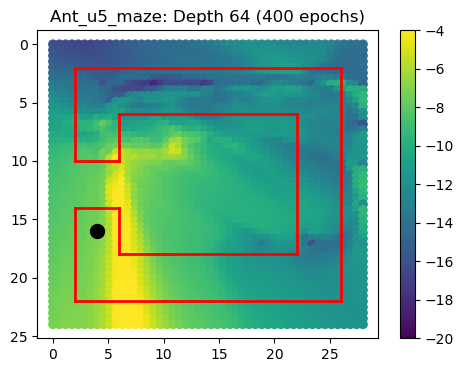

In [13]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o', vmin=-20, vmax=-4)
plt.colorbar()

plt.plot([2, 26], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 26], [2, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 2], [22, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [22, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 6], [14, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [14, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 22], [18, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 22], [18, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 6], [6, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [6, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 2], [10, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [10, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)



plt.scatter(goal[1], goal[0], color='black', s=100)

plt.gca().invert_yaxis()

plt.title(f"Ant_u5_maze: Depth {depth} (400 epochs)")

plt.show()

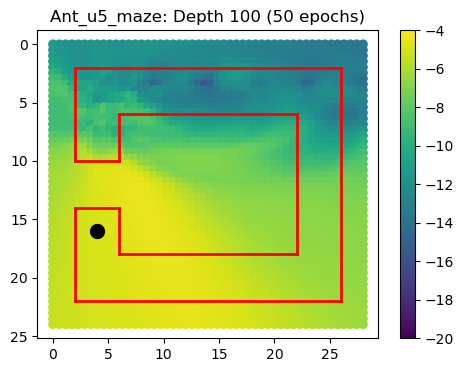

In [28]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o', vmin=-20, vmax=-4)
plt.colorbar()

plt.plot([2, 26], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 26], [2, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 2], [22, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [22, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 6], [14, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [14, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 22], [18, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 22], [18, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 6], [6, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [6, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 2], [10, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [10, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)



plt.scatter(goal[1], goal[0], color='black', s=100)

plt.gca().invert_yaxis()

plt.title(f"Ant_u5_maze: Depth {depth} (50 epochs)")

plt.show()

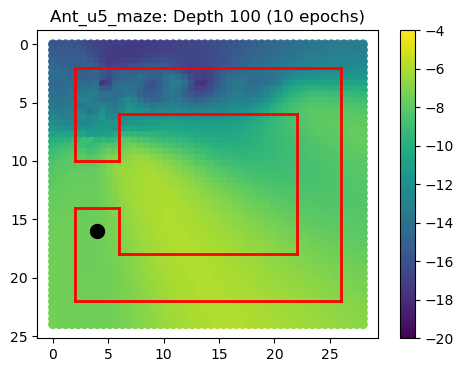

In [13]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o', vmin=-20, vmax=-4)
plt.colorbar()

plt.plot([2, 26], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 26], [2, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 2], [22, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [22, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 6], [14, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [14, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 22], [18, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 22], [18, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 6], [6, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [6, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 2], [10, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [10, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)



plt.scatter(goal[1], goal[0], color='black', s=100)

plt.gca().invert_yaxis()

plt.title(f"Ant_u5_maze: Depth {depth} (10 epochs)")

plt.show()

In [ ]:
goal

In [ ]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 26], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 26], [2, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 2], [22, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [22, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 6], [14, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [14, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 22], [18, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 22], [18, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 6], [6, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [6, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 2], [10, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [10, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)



plt.scatter(goal[1], goal[0], color='black', s=100)

plt.gca().invert_yaxis()

plt.title(f"Ant_u5_maze: Depth {depth}")

plt.show()

In [ ]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.gca().invert_yaxis()

plt.title(f"Depth {depth}")

plt.show()

In [ ]:
plt.figure(figsize=(5.5, 4))
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.plot([2, 14], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([14, 14], [2, 14], color='red', linewidth=2) # Line from (16,4) to (16,16)
plt.plot([14, 2], [14, 14], color='red', linewidth=2) # Line from (16,16) to (4,16)

plt.plot([2, 10], [6, 6], color='red', linewidth=2)    # Line from (4,8) to (12,8)
plt.plot([10, 10], [6, 10], color='red', linewidth=2)  # Line from (12,8) to (12,12)
plt.plot([10, 2], [10, 10], color='red', linewidth=2)  # Line from (12,12) to (4,12)

plt.plot([2, 2], [2, 6], color='red', linewidth=2)     # Line from (4,4) to (4,8)
plt.plot([2, 2], [10, 14], color='red', linewidth=2)   # Line from (4,12) to (1,16)

plt.scatter(goal[1], goal[0], color='black', s=100)

plt.gca().invert_yaxis()

plt.title(f"Depth {depth}")

plt.show()

In [ ]:
# # First, here's the complete code for U4 maze heatmap

# import numpy as np
# import matplotlib.pyplot as plt
# import jax
# import jax.numpy as jnp

# # Setup the grid
# x = np.linspace(0, 16, 50)  # Keep x the same as it's still 5 cells wide
# y = np.linspace(0, 26, 50)  # Adjust for 7 cells height

# X, Y = np.meshgrid(x, y)
# Z = np.zeros_like(X)

# # Assuming we have the same policy_step and encoder functions as before
# @jax.jit
# def policy_step(env_state, actor_params):
#     means, _ = actor.apply(actor_params, env_state.obs)
#     actions = nn.tanh(means)
#     return actions

# # Compute the heatmap values
# rng = jax.random.PRNGKey(SEED)
# env_state = jax.jit(env.reset)(rng)

# for i in range(len(x)):
#     for j in range(len(y)):
#         obs[:2] = (x[i], y[j])
#         actions = policy_step(env_state, actor_params)
#         act = np.array(actions)
        
#         encoded_state_action = sa_encoder.apply(sa_encoder_params, obs[:-2], act)
#         encoded_goal = g_encoder.apply(g_encoder_params, goal)
#         l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
#         Z[i, j] = - l2_distance
#         print(f"Z[{x[i]}, {y[j]}]: {Z[i, j]}")

# # Plot the heatmap
# plt.figure(figsize=(5.5, 7))  # Adjusted figure size for taller maze
# plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
# plt.colorbar()

# # Draw the U4 maze walls
# # Vertical walls
# plt.plot([2, 2], [2, 26], color='red', linewidth=2)    # Left wall
# plt.plot([14, 14], [2, 26], color='red', linewidth=2)  # Right wall

# # Horizontal walls
# plt.plot([2, 14], [2, 2], color='red', linewidth=2)    # Bottom wall
# plt.plot([2, 14], [26, 26], color='red', linewidth=2)  # Top wall

# # Internal walls
# plt.plot([6, 6], [6, 22], color='red', linewidth=2)    # Middle vertical wall
# plt.plot([6, 10], [10, 10], color='red', linewidth=2)  # Middle horizontal wall

# plt.scatter(goal[1], goal[0], color='black', s=100)    # Goal point

# plt.gca().invert_yaxis()  # Invert y-axis to match maze layout
# plt.title(f"U4 Maze Depth {depth}")

# plt.show()

In [18]:
SEED = 4237

rng = jax.random.PRNGKey(seed=SEED)
env_state = jax.jit(env.reset)(rng)

obs = np.array(env_state.obs)
goal = obs[-2:]
print(f"goal: {goal}")

# # Setup the grid
# x = np.linspace(0, 16, 50)  # Keep x the same as it's still 5 cells wide
# y = np.linspace(0, 26, 50)  # Adjust for 7 cells height

# X, Y = np.meshgrid(x, y)
# Z = np.zeros_like(X)

# # Assuming we have the same policy_step and encoder functions as before
# @jax.jit
# def policy_step(env_state, actor_params):
#     means, _ = actor.apply(actor_params, env_state.obs)
#     actions = nn.tanh(means)
#     return actions

# # Compute the heatmap values
# rng = jax.random.PRNGKey(SEED)
# env_state = jax.jit(env.reset)(rng)

# for i in range(len(x)):
#     for j in range(len(y)):
#         obs[:2] = (x[i], y[j])
#         actions = policy_step(env_state, actor_params)
#         act = np.array(actions)
        
#         encoded_state_action = sa_encoder.apply(sa_encoder_params, obs[:-2], act)
#         encoded_goal = g_encoder.apply(g_encoder_params, goal)
#         l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
#         Z[i, j] = - l2_distance
#         if j == 0 or j == len(y) - 1:
#             print(f"Z[{x[i]}, {y[j]}]: {Z[i, j]}")

def policy_step(obs, actor_params):
    means, _ = actor.apply(actor_params, obs)
    actions = nn.tanh(means)
    return actions


obs = np.array(env_state.obs)
goal = obs[-2:]

x = np.linspace(0, 28, 56)
y = np.linspace(0, 24, 48)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

rng = jax.random.PRNGKey(seed=SEED)

for i in range(len(x)):
    for j in range(len(y)):
        obs[:2] = (y[j], x[i])
        action = policy_step(obs, actor_params)
        act = np.array(action)
        
        encoded_state_action = sa_encoder.apply(sa_encoder_params, obs[:-2], act)
        encoded_goal = g_encoder.apply(g_encoder_params, goal)
        l2_distance = np.linalg.norm(encoded_state_action - encoded_goal)
        Z[j, i] = - l2_distance
        if j == 0 or j == len(y) - 1:
            print(f"Z[{x[i]}, {y[j]}]: {Z[j, i]}")

goal: [16.  4.]
Z[0.0, 0.0]: -19.863157272338867
Z[0.0, 24.0]: -3.863823652267456
Z[0.509090909090909, 0.0]: -19.61151695251465
Z[0.509090909090909, 24.0]: -3.727895498275757
Z[1.018181818181818, 0.0]: -19.351966857910156
Z[1.018181818181818, 24.0]: -3.632695198059082
Z[1.5272727272727271, 0.0]: -19.053293228149414
Z[1.5272727272727271, 24.0]: -3.582240343093872
Z[2.036363636363636, 0.0]: -18.70134925842285
Z[2.036363636363636, 24.0]: -3.5773584842681885
Z[2.545454545454545, 0.0]: -18.312610626220703
Z[2.545454545454545, 24.0]: -3.618591070175171
Z[3.0545454545454542, 0.0]: -17.926605224609375
Z[3.0545454545454542, 24.0]: -3.7053942680358887
Z[3.5636363636363635, 0.0]: -17.582706451416016
Z[3.5636363636363635, 24.0]: -3.8340771198272705
Z[4.072727272727272, 0.0]: -17.30064582824707
Z[4.072727272727272, 24.0]: -3.9976115226745605
Z[4.581818181818181, 0.0]: -17.075504302978516
Z[4.581818181818181, 24.0]: -4.187455654144287
Z[5.09090909090909, 0.0]: -16.891460418701172
Z[5.09090909090909,

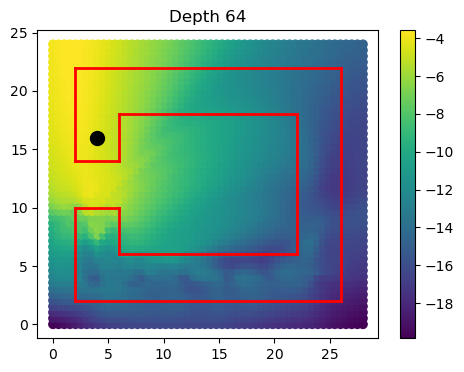

In [32]:
plt.figure(figsize=(5.5, 4))  # Adjusted figure size for taller maze
plt.scatter(X, Y, c=Z, cmap='viridis', marker='o')
plt.colorbar()

plt.title(f"Depth {depth}")

plt.plot([2, 26], [2, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 26], [2, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([26, 2], [22, 22], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [22, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 6], [14, 14], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [14, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 22], [18, 18], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 22], [18, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([22, 6], [6, 6], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 6], [6, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([6, 2], [10, 10], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.plot([2, 2], [10, 2], color='red', linewidth=2)   # Line from (4,4) to (16,4)
plt.scatter(goal[1], goal[0], color='black', s=100)

plt.show()